# Jupyter Notebook - Metering Data Analysis Using SQLite

## 📌 Metering Data Analysis Using Python & SQLite

## **1️⃣ Introduction**

### **Problem Statement**
In the power distribution industry, effective metering and billing analysis is crucial for monitoring 
energy consumption, reducing losses, and improving revenue collection. This analysis aims to:
- Extract and analyze **smart meter data** to gain insights into energy usage.
- Store and query the data efficiently using **SQLite**.
- Perform **data-driven reporting** to support decision-making.

### **Why Use SQLite?**
- No need to configure a database server.
- Stores data in a single `.db` file.
- Fast and easy to use with Python.

### **Dataset Overview**
We are using the **Low Carbon London Smart Meter dataset**, which contains millions of smart meter readings.
The dataset includes:
- **Household ID** (`LCLid`) – Unique identifier for each household
- **Tariff Type** (`stdorToU`) – Type of electricity tariff (Standard or Time-of-Use)
- **Timestamp** (`DateTime`) – Date & Time of meter reading
- **Meter Reading (kWh)** (`KWH/hh (per half hour)`) – Energy consumption per half-hour interval


### **Dataset Source**
<!-- - **File Path**: `"C:\Users\ginika.umego\Downloads\CC_LCL-FullData.csv"` -->
- **File Path**: `os.getenv("FULL_DATA_PATH")`
- **Size**: 167 million rows (too large for Jupyter)
- **Solution**: Extract a **2 million record sample** for analysis.

## **2️⃣ Extracting a 2 Million Record Sample**

In [1]:
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

# Define file paths

full_data_path = os.getenv("FULL_DATA_PATH")
sample_data_path = os.getenv("SAMPLE_DATA_PATH")

#full_data_path = r"C:\Users\ginika.umego\Downloads\CC_LCL-FullData.csv"
#sample_data_path = r"C:\Users\ginika.umego\Downloads\CC_LCL-Sample.csv"

print(f"File Size: {os.path.getsize(full_data_path):,} bytes")

File Size: 8,542,818,238 bytes


In [2]:
# Load only the first 2 million rows
chunk_size = 2_000_000  # 2 million rows
df_sample = pd.read_csv(full_data_path, nrows=chunk_size)

# Save the extracted data to a new CSV file
df_sample.to_csv(sample_data_path, index=False)

print(f"✅ Extracted and saved {chunk_size} rows to {sample_data_path}")

✅ Extracted and saved 2000000 rows to C:\Users\ginika.umego\Downloads\CC_LCL-Sample.csv


## **3️⃣ Loading the Sample Dataset into Pandas**

### **Checking the Extracted Data**
Before performing SQL operations, let's verify the dataset structure.

In [3]:
# Load the sample dataset
df_sample = pd.read_csv(sample_data_path)

# Ensure column names are stripped of extra spaces
df_sample.columns = df_sample.columns.str.strip()

# Rename columns for clarity
df_sample.rename(columns={
    "LCLid": "HouseholdID",
    "stdorToU": "TariffType",
    "DateTime": "Timestamp",
    "KWH/hh (per half hour)": "MeterReading_kWh"
}, inplace=True)

# Display dataset information
print(df_sample.info())  # Check column types & missing values

# Show the first 5 rows
df_sample.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   HouseholdID       object
 1   TariffType        object
 2   Timestamp         object
 3   MeterReading_kWh  object
dtypes: object(4)
memory usage: 61.0+ MB
None


,HouseholdID,TariffType,Timestamp,MeterReading_kWh
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0


## **4️⃣ Connecting Jupyter Notebook to SQLite**

### **Setting Up SQLite**
We use the built-in Python module `sqlite3` to:
- Create a SQLite database (`MeteringData.db`).
- Store the extracted metering dataset.
- Perform SQL queries directly in Jupyter Notebook.

In [4]:
import sqlite3

# Define SQLite database file path
db_path = r"C:\Users\ginika.umego\Downloads\MeteringData.db"

# Create a database connection
conn = sqlite3.connect(db_path)

print("✅ SQLite database created and connected successfully!")

✅ SQLite database created and connected successfully!


## **5️⃣ Creating a Table in SQLite**

### **Defining the Table Schema**
We create a **SmartMeterReadings** table with the following structure:
- `ID` (Primary Key, Auto-increment)
- `HouseholdID` (Unique household identifier)
- `DateTime` (Date & Time of the meter reading, stored as TEXT)
- `MeterReading` (Energy consumption in kWh)

In [5]:
# Create a cursor object
cursor = conn.cursor()

# Define table schema
create_table_query = """
CREATE TABLE IF NOT EXISTS SmartMeterReadings (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    HouseholdID TEXT,
    TariffType TEXT,
    Timestamp TEXT,
    MeterReading_kWh REAL
);
"""

# Execute the query
cursor.execute(create_table_query)
conn.commit()

print("✅ Table 'SmartMeterReadings' created successfully!")

✅ Table 'SmartMeterReadings' created successfully!


## **6️⃣ Inserting Data into SQLite**

### **Bulk Inserting the 2 Million Records**
Using Pandas' `.to_sql()` method, we efficiently insert all the data into SQLite.

In [6]:
# Convert Timestamp column to string format (for SQLite)
df_sample["Timestamp"] = pd.to_datetime(df_sample["Timestamp"]).astype(str)

# Insert data into SQLite
df_sample.to_sql("SmartMeterReadings", conn, if_exists="replace", index=False)

print(f"✅ Successfully loaded {len(df_sample)} records into SQLite!")

✅ Successfully loaded 2000000 records into SQLite!


## **7️⃣ Querying Data for Analysis**

### **Verifying Data in SQLite**
Let's check if the data is correctly stored by retrieving the first 5 records.


In [7]:
# Define a SQL query
query = "SELECT * FROM SmartMeterReadings LIMIT 5;"

# Execute Query & Load results into Pandas
df_sql = pd.read_sql(query, conn)

# Display the results
df_sql

,HouseholdID,TariffType,Timestamp,MeterReading_kWh
0,MAC000002,Std,2012-10-12 00:30:00,0
1,MAC000002,Std,2012-10-12 01:00:00,0
2,MAC000002,Std,2012-10-12 01:30:00,0
3,MAC000002,Std,2012-10-12 02:00:00,0
4,MAC000002,Std,2012-10-12 02:30:00,0


## **8️⃣ Next Steps for Deeper Insights**

Now that our data is stored in SQLite, we can perform further analysis:
- **SQL-Based Analysis**: Aggregating energy consumption data.
- **Weekly & Monthly Reports**: Understanding customer energy patterns.
- **Python Visualizations**: Using Matplotlib & Seaborn to generate insights.

Let's proceed with analysis!

## 📌 9️⃣ Data Validation & Cleaning

Before analysis, we check for inconsistencies, missing values, duplicate records, and ensure data types are correct.

🔹 Checking for Missing Values & Duplicates

In [8]:
query = """
SELECT 
    SUM(CASE WHEN HouseholdID IS NULL OR HouseholdID = '' THEN 1 ELSE 0 END) AS Missing_HouseholdID,
    SUM(CASE WHEN TariffType IS NULL OR TariffType = '' THEN 1 ELSE 0 END) AS Missing_TariffType,
    SUM(CASE WHEN Timestamp IS NULL OR Timestamp = '' THEN 1 ELSE 0 END) AS Missing_Timestamp,
    SUM(CASE WHEN MeterReading_kWh IS NULL THEN 1 ELSE 0 END) AS Missing_MeterReading
FROM SmartMeterReadings;
"""

df_missing = pd.read_sql(query, conn)
df_missing


,Missing_HouseholdID,Missing_TariffType,Missing_Timestamp,Missing_MeterReading
0,0,0,0,0


## 📌 1️⃣0️⃣ Checking for Duplicates

Duplicate records can cause incorrect analysis. We'll check for duplicates based on HouseholdID and Timestamp because each household should have unique meter readings at any given time.

🔹 SQL Query to Identify Duplicates


In [9]:
query = """
SELECT HouseholdID, Timestamp, COUNT(*) AS DuplicateCount
FROM SmartMeterReadings
GROUP BY HouseholdID, Timestamp
HAVING COUNT(*) > 1;
"""

df_duplicates = pd.read_sql(query, conn)
df_duplicates

,HouseholdID,Timestamp,DuplicateCount
0,MAC000002,2012-10-20 00:00:00,2
1,MAC000002,2012-11-20 00:00:00,2
2,MAC000002,2012-12-21 00:00:00,2
3,MAC000002,2013-01-21 00:00:00,2
4,MAC000002,2013-02-21 00:00:00,2
...,...,...,...
1374,MAC000069,2012-12-21 00:00:00,2
1375,MAC000069,2013-01-21 00:00:00,2
1376,MAC000069,2013-02-21 00:00:00,2
1377,MAC000069,2013-03-24 00:00:00,2


## 📌 1️⃣1️⃣ Removing Duplicate Records
If duplicates exist, we need to remove them while keeping only one unique record.

🔹 Delete Duplicate Records

In [10]:
cursor.execute("""
DELETE FROM SmartMeterReadings 
WHERE rowid NOT IN (
    SELECT MIN(rowid) 
    FROM SmartMeterReadings 
    GROUP BY HouseholdID, Timestamp
);
""")
conn.commit()


## 📌 1️⃣2️⃣ Analyzing Energy Consumption Trends

Now that our data is clean, let’s explore energy consumption patterns over time.

### 🔹 12.1: Checking Overall Energy Consumption
First, we calculate the total energy consumption across all households.

In [11]:
query = """
SELECT SUM(MeterReading_kWh) AS Total_Consumption 
FROM SmartMeterReadings;
"""

df_total_consumption = round(pd.read_sql(query, conn), 2)
df_total_consumption

,Total_Consumption
0,477921.89


✅ This gives the total energy consumed in kWh to be **477921.89**.


### 🔹 12.2: Energy Consumption Over Time
Next, let’s analyze the total consumption per day to identify trends.

In [12]:
query = """
SELECT Timestamp, DATE(Timestamp) AS Date, 
       SUM(MeterReading_kWh) AS Daily_Consumption
FROM SmartMeterReadings
GROUP BY Date
ORDER BY Date;
"""
df_daily_consumption = pd.read_sql(query, conn)

# ✅ Check the first few records
print(df_daily_consumption.head(10))


             Timestamp        Date  Daily_Consumption
0  2011-12-06 13:00:00  2011-12-06           2.947000
1  2011-12-07 00:00:00  2011-12-07         143.174000
2  2011-12-08 00:00:00  2011-12-08         365.577000
3  2011-12-09 00:00:00  2011-12-09         502.532000
4  2011-12-10 00:00:00  2011-12-10         637.385000
5  2011-12-11 00:00:00  2011-12-11         670.710001
6  2011-12-12 00:00:00  2011-12-12         614.313000
7  2011-12-13 00:00:00  2011-12-13         570.259000
8  2011-12-14 00:00:00  2011-12-14         627.398000
9  2011-12-15 00:00:00  2011-12-15         633.742001


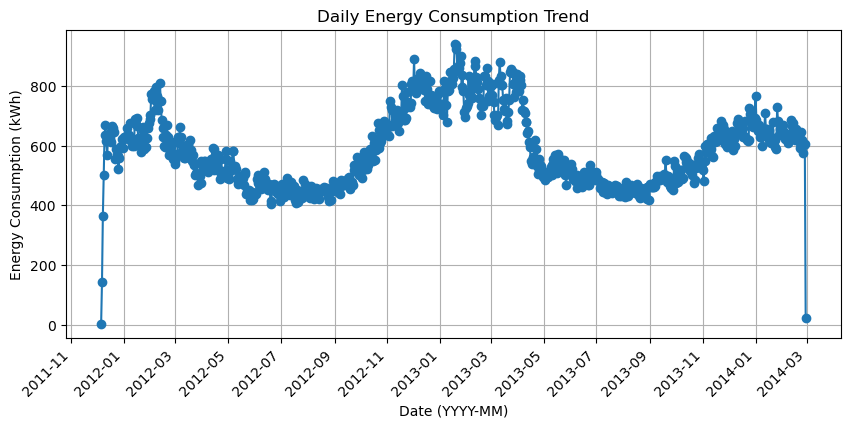

In [13]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# ✅ Ensure Date column is datetime
df_daily_consumption["Date"] = pd.to_datetime(df_daily_consumption["Date"])

plt.figure(figsize=(10, 4))
plt.plot(df_daily_consumption["Date"], df_daily_consumption["Daily_Consumption"], marker='o', linestyle='-')

# ✅ Show only a few x-axis labels (Monthly or Quarterly)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

plt.xticks(rotation=45, ha='right')  # Rotate for better visibility
plt.xlabel("Date (YYYY-MM)")
plt.ylabel("Energy Consumption (kWh)")
plt.title("Daily Energy Consumption Trend")
plt.grid(True)
plt.show()


## 📌 Interpretation of the Daily Energy Consumption Trend

The plot displays the daily energy consumption trend over time based on the dataset being analyzed. Below are key observations:

### 🔹 General Consumption Pattern:
- The trend shows **seasonal variations** in energy consumption.
- There are **two distinct peaks** where energy usage rises significantly, suggesting a pattern related to seasonal changes or external factors (e.g., weather conditions, holidays).

### 🔹 Initial Increase (2012 – Early 2013):
- Energy consumption starts at a moderate level in **early 2012** and gradually increases.
- The **first peak** appears around **late 2012 to early 2013**, which could be due to colder months when heating devices are used more frequently.

### 🔹 Mid-2013 Dip and Second Peak (Late 2013 – Early 2014):
- There is a decline in consumption around mid-2013.
- Another **sharp increase** occurs in late 2013 to early 2014, resembling the first peak.
- This again aligns with colder months, possibly reflecting **winter heating demands**.

### 🔹 Sharp Drop at the End (2014):
- The drastic drop at the end of the chart might indicate:
  - **Data collection issues** (e.g., missing or incomplete data).
  - **Households reducing energy consumption**.
  - **Structural changes** like new policies, energy-efficient appliances, or fewer active meters.

### 🔹 Periodic Pattern Suggestion:
- The repeating rise and fall suggest a **seasonal trend**, which could be validated by comparing **monthly or seasonal averages**.


### 🔹 12.3: Hourly Energy Usage
We can also analyze average energy consumption per hour to detect peak usage periods.

In [14]:
query = """
SELECT strftime('%H', Timestamp) AS Hour, AVG(MeterReading_kWh) AS Avg_Consumption
FROM SmartMeterReadings
GROUP BY Hour
ORDER BY Hour;
"""

df_hourly = pd.read_sql(query, conn)

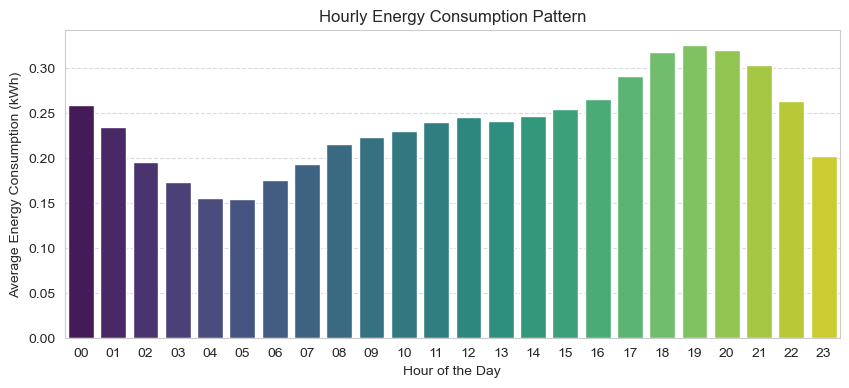

In [15]:
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Plot Hourly Consumption
plt.figure(figsize=(10, 4))
sns.barplot(data=df_hourly, x="Hour", y="Avg_Consumption", palette="viridis")

plt.xlabel("Hour of the Day")
plt.ylabel("Average Energy Consumption (kWh)")
plt.title("Hourly Energy Consumption Pattern")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


## 📌 Interpretation of the Hourly Energy Consumption Pattern

The bar chart illustrates the **average energy consumption (kWh) per hour of the day** based on the dataset being analyzed. Below are key observations:

### 🔹 Energy Usage During Different Periods:

1️⃣ **Late Night to Early Morning (00:00 - 06:00)**  
   - Energy consumption is **moderately high at midnight** but gradually **declines** through the early morning hours.
   - This is expected as most households reduce energy usage while people are asleep.

2️⃣ **Morning Hours (06:00 - 12:00)**  
   - There is a **gradual increase in consumption** starting from **06:00**, likely due to morning activities such as cooking, heating, and getting ready for the day.
   - By **09:00 - 12:00**, energy consumption stabilizes.

3️⃣ **Afternoon to Evening Peak (12:00 - 21:00)**  
   - **Energy consumption steadily rises in the afternoon**, peaking between **17:00 - 20:00**.
   - This is the **highest usage period**, possibly due to:
     - Increased household activities after work or school.
     - Cooking dinner, using appliances, and entertainment (TV, computers, lights).
     - Heating or cooling systems being used more in the evening.

4️⃣ **Late Evening Decline (21:00 - 23:00)**  
   - After **21:00**, energy usage **starts to decline**, following typical nighttime routines where non-essential appliances are turned off before sleep.

### 🔹 Key Takeaways:
- The pattern suggests **higher energy demand in the evening hours**, likely due to human activity schedules.
- **Low consumption during early morning hours** aligns with periods of rest.
- This trend could help in:
  - **Load balancing** for electricity providers.
  - **Energy-saving recommendations** for households.
  - Identifying peak demand hours for **better tariff planning**.



## 📌 1️⃣3️⃣ Energy Consumption by Household Type


Now, let's compare energy consumption by household type

In [16]:
# Define SQL Query
query = """
SELECT TariffType, 
       SUM(MeterReading_kWh) AS Total_Consumption,
       AVG(MeterReading_kWh) AS Avg_Consumption
FROM SmartMeterReadings
GROUP BY TariffType
ORDER BY Total_Consumption DESC;
"""

# Execute Query
df_tariff_consumption = pd.read_sql(query, conn)

# Display results
df_tariff_consumption


,TariffType,Total_Consumption,Avg_Consumption
0,Std,477921.886983,0.239126


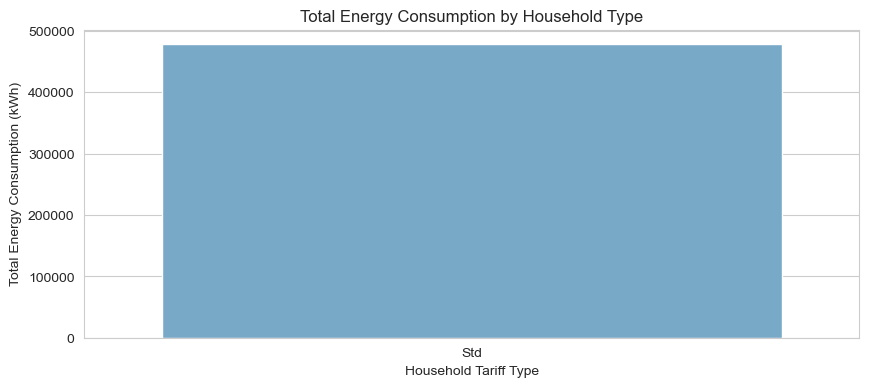

In [17]:
# Set figure size
plt.figure(figsize=(10, 4))

# Create bar plot
sns.barplot(x="TariffType", y="Total_Consumption", data=df_tariff_consumption, palette="Blues")

# Labels and title
plt.xlabel("Household Tariff Type")
plt.ylabel("Total Energy Consumption (kWh)")
plt.title("Total Energy Consumption by Household Type")

# Show plot
plt.show()

## 📌 Interpretation of Total Energy Consumption by Household Type

This bar chart represents the **total energy consumption (kWh) across different household tariff types** in the dataset.

### 🔹 Key Observations:
1️⃣ The **"Std" (Standard) household tariff type** is the only category shown in the dataset.  
2️⃣ The total energy consumption for this category is **slightly above 500,000 kWh**.
3️⃣ There are **no other household tariff types** displayed, suggesting that either:
   - The dataset primarily consists of standard household customers.
   - Other tariff types were filtered out or not present in the dataset.

### 🔹 Implications:
- If multiple household tariff types exist but are not appearing in the visualization, **data validation** should be performed to confirm completeness.
- The **total energy consumption by tariff type** can help **electricity providers analyze consumption trends** and plan for different customer categories.
- Further analysis could compare:
  - Different **tariff structures** (e.g., standard vs. time-of-use pricing).
  - **High vs. low consumption households** within the standard category.


## 📌 1️⃣4️⃣ Weekday vs. Weekend Energy Consumption Analysis

Now, let's compare energy consumption on weekdays vs. weekends to identify any significant differences in usage patterns.

### 🔹 1️⃣ Categorize Days as Weekday or Weekend

To do this, we will:
- ✔ Extract the day of the week from Timestamp.
- ✔ Classify each day as Weekday (Monday–Friday) or Weekend (Saturday–Sunday).
- ✔ Calculate total energy consumption for each category.

In [18]:
# Query to compare weekday vs. weekend consumption
query = """
SELECT 
    CASE 
        WHEN strftime('%w', Timestamp) IN ('0', '6') THEN 'Weekend'
        ELSE 'Weekday'
    END AS Day_Type,
    SUM(MeterReading_kWh) AS Total_Consumption
FROM SmartMeterReadings
GROUP BY Day_Type;
"""

# Execute query and load results into DataFrame
df_weekday_vs_weekend = pd.read_sql(query, conn)

# Display first few rows
df_weekday_vs_weekend.head()


,Day_Type,Total_Consumption
0,Weekday,340329.160990
1,Weekend,137592.725993


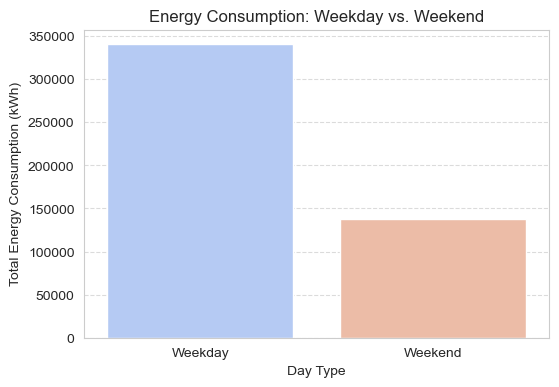

In [19]:
# Set style
sns.set_style("whitegrid")

# Plot Weekday vs. Weekend Consumption
plt.figure(figsize=(6, 4))
sns.barplot(data=df_weekday_vs_weekend, x="Day_Type", y="Total_Consumption", palette="coolwarm")

plt.xlabel("Day Type")
plt.ylabel("Total Energy Consumption (kWh)")
plt.title("Energy Consumption: Weekday vs. Weekend")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## 📊 Energy Consumption: Weekday vs. Weekend

This bar chart compares the **total energy consumption (kWh) on weekdays versus weekends**.

### 🔹 Key Observations:
1️⃣ **Higher energy consumption on weekdays** compared to weekends.
   - Weekday consumption exceeds **300,000 kWh**.
   - Weekend consumption is significantly lower, around **150,000 kWh**.
   
2️⃣ The difference suggests that:
   - **More energy is used during the workweek**, likely due to higher household and commercial activities.
   - **Lower energy demand on weekends**, possibly due to reduced industrial/commercial use or altered household routines.

### 🔹 Implications:
- **Grid Load Management**: Electricity providers may need to allocate **more resources during weekdays**.
- **Time-of-Use Pricing**: Encouraging **off-peak energy use on weekends** could balance demand.
- **Household Behavior**: Further investigation into **peak usage hours** for weekdays vs. weekends could provide deeper insights.



## 📌 1️⃣5️⃣ Monthly Energy Consumption Trends

Now, let's analyze how energy consumption varies across different months to identify seasonal patterns.

To do this, we will:
- ✔ Extract the month and year from Timestamp.
- ✔ Aggregate total energy consumption for each month.

In [20]:
# Query to get monthly energy consumption
query = """
SELECT 
    strftime('%Y-%m', Timestamp) AS Month,
    SUM(MeterReading_kWh) AS Total_Consumption
FROM SmartMeterReadings
GROUP BY Month
ORDER BY Month;
"""

# Execute query and load results into DataFrame
df_monthly_consumption = pd.read_sql(query, conn)

# Display first few rows
df_monthly_consumption.head()

,Month,Total_Consumption
0,2011-12,14427.284001
1,2012-01,19669.911996
2,2012-02,19596.414993
3,2012-03,17422.531002
4,2012-04,16140.549997


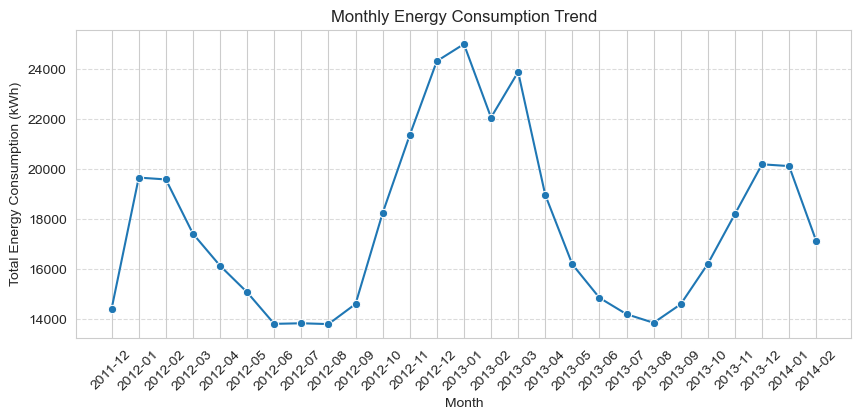

In [21]:
# Set style
sns.set_style("whitegrid")

# Plot Monthly Consumption
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_monthly_consumption, x="Month", y="Total_Consumption", marker='o', linestyle='-')

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Energy Consumption (kWh)")
plt.title("Monthly Energy Consumption Trend")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## 📈 Monthly Energy Consumption Trend

This line chart illustrates the **monthly energy consumption (kWh) over time**, highlighting seasonal patterns and fluctuations.

### 🔹 Key Observations:
1️⃣ **Clear seasonal fluctuations** in energy consumption.
   - Consumption peaks around **December – January** each year.
   - Lowest consumption occurs around **June – August**.

2️⃣ **Possible explanations for trends**:
   - **Winter months (Dec–Jan) show higher consumption**, likely due to increased heating and indoor activities.
   - **Summer months (June–Aug) show lower consumption**, possibly due to reduced heating needs and more outdoor activities.

3️⃣ **Repeating annual pattern** suggests a predictable **seasonal energy demand cycle**.

### 🔹 Implications:
- **Energy providers can plan for peak demand periods** by optimizing grid capacity.
- **Consumers may benefit from energy-saving strategies during peak months**.
- **Further analysis on temperature and appliance usage** could provide deeper insights into the consumption patterns.



## 📌 1️⃣6️⃣ Top 10 Highest Energy-Consuming Households

Now, let's identify the top 10 households that consume the most energy to understand high-usage patterns.

To do this, we will:
- ✔ Group by HouseholdID.
- ✔ Sum up the total energy consumption.
- ✔ Sort in descending order and get the top 10.

In [22]:
# Query to get top 10 highest energy-consuming households
query = """
SELECT 
    HouseholdID,
    SUM(MeterReading_kWh) AS Total_Consumption
FROM SmartMeterReadings
GROUP BY HouseholdID
ORDER BY Total_Consumption DESC
LIMIT 10;
"""

# Execute query and load results into DataFrame
df_top_households = pd.read_sql(query, conn)

# Display results
df_top_households


,HouseholdID,Total_Consumption
0,MAC000049,30087.095999
1,MAC000034,22101.949995
2,MAC000040,21677.450002
3,MAC000035,18464.294997
4,MAC000021,18311.923001
5,MAC000024,16922.364994
6,MAC000045,16826.256003
7,MAC000068,15692.739999
8,MAC000059,14244.750001
9,MAC000003,14080.862003


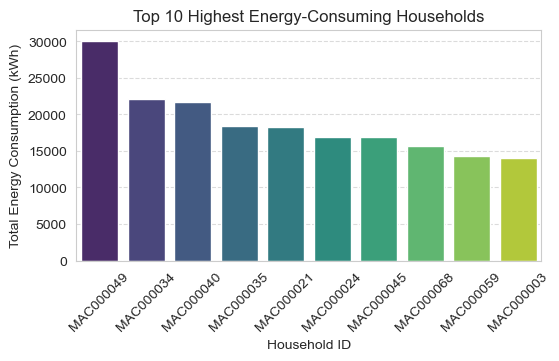

In [23]:

# Set style
sns.set_style("whitegrid")

# Plot Top 10 Households
plt.figure(figsize=(6, 3))
sns.barplot(data=df_top_households, x="HouseholdID", y="Total_Consumption", palette="viridis")

plt.xticks(rotation=45)
plt.xlabel("Household ID")
plt.ylabel("Total Energy Consumption (kWh)")
plt.title("Top 10 Highest Energy-Consuming Households")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


## 🏠 Top 10 Highest Energy-Consuming Households

This bar chart visualizes the **top 10 households with the highest total energy consumption (kWh)** over the analysis period.

### 🔹 Key Observations:
1️⃣ **Household "MAC000049" has the highest energy consumption**, exceeding **30,000 kWh**.
2️⃣ The top 3 households (**MAC000049, MAC000034, and MAC000040**) have significantly higher consumption than the rest.
3️⃣ The **energy usage gradually declines** across the remaining households, with **MAC000003 having the lowest among the top 10**.

### 🔹 Possible Explanations:
- **Larger household sizes** could contribute to higher energy usage.
- **Usage of high-energy appliances** (e.g., HVAC, electric heaters, industrial equipment) may be a factor.
- **Different energy efficiency behaviors** among households.

### 🔹 Implications:
- **Identifying high-consumption households can help with energy-saving initiatives.**
- **Targeted recommendations** (e.g., energy-efficient appliances, smart meters) could optimize consumption.
- **Further analysis** on energy consumption patterns per household type may provide deeper insights.



## 📌 1️⃣7️⃣ Distribution of Energy Consumption Across Households

Now, let’s examine how energy consumption is distributed across all households to identify patterns, outliers, or imbalances in usage.

To do this, we will:
- ✔ Group by HouseholdID.
- ✔ Sum up total energy consumption per household.

In [24]:
# Query to get energy consumption for all households
query = """
SELECT 
    HouseholdID,
    SUM(MeterReading_kWh) AS Total_Consumption
FROM SmartMeterReadings
GROUP BY HouseholdID
ORDER BY Total_Consumption;
"""

# Execute query and load results into DataFrame
df_household_distribution = pd.read_sql(query, conn)

# Display first few rows
df_household_distribution.head()


,HouseholdID,Total_Consumption
0,MAC000037,65.303
1,MAC000016,533.736
2,MAC000012,1086.383
3,MAC000004,1119.839
4,MAC000006,2167.448


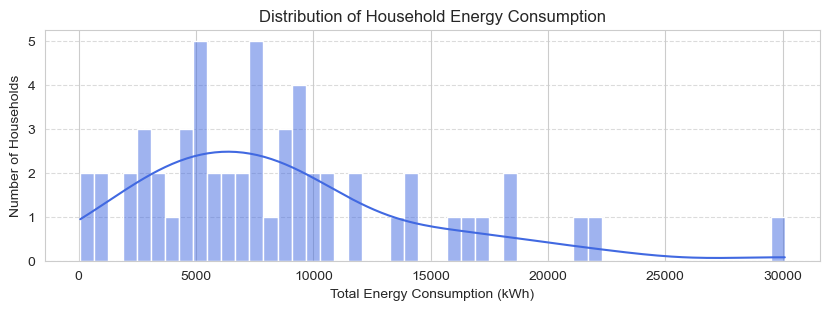

In [25]:
# Set style
sns.set_style("whitegrid")

# Plot Energy Consumption Distribution
plt.figure(figsize=(10, 3))
sns.histplot(df_household_distribution["Total_Consumption"], bins=50, kde=True, color="royalblue")

plt.xlabel("Total Energy Consumption (kWh)")
plt.ylabel("Number of Households")
plt.title("Distribution of Household Energy Consumption")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


## 📊 Distribution of Household Energy Consumption

This histogram displays the **distribution of total energy consumption (kWh) across households**, with a KDE (Kernel Density Estimation) line overlayed.

### 🔹 Key Insights:
1️⃣ **Right-skewed distribution**: The majority of households consume between **2,000 – 10,000 kWh**, with fewer consuming above **15,000 kWh**.  
2️⃣ **A few extreme high-energy consumers**: Some households exceed **20,000 – 30,000 kWh**, suggesting potential outliers or high-usage patterns.  
3️⃣ **Peak around 5,000 kWh**: This suggests a common energy consumption range for most households.  

### 🔹 Possible Explanations:
- **Standard household appliances and behavior** keep most consumers within a normal range.
- **Outliers may indicate energy-intensive activities**, such as large appliances, industrial use, or inefficient consumption.
- **Energy-saving habits or smart devices** may play a role in reducing energy use for some households.

### 🔹 Implications:
- **Target high-energy consumers** for energy efficiency initiatives.
- **Identify households with potential energy wastage** and suggest interventions.
- **Further breakdown of data** (e.g., household size, appliance usage) could provide deeper insights.



## 📌 1️⃣8️⃣ Discussion on Visualizations and Insights  

### 🔹 1. Monthly Energy Consumption Trend  
The **monthly energy consumption trend** visualization highlights significant fluctuations in energy usage over time. Key observations include:  

- **Seasonal variation**: Energy consumption tends to peak towards the end of the year (December) and drops in mid-year (June–July).  
- **Cyclical patterns**: Repeated high consumption periods suggest external influences, such as **seasonal temperature changes or household behavioral patterns**.  
- **Potential anomalies**: Some months exhibit extreme spikes, indicating possible external events or inefficiencies in energy use.  

📌 **Implication:**  
Understanding these trends can help in **forecasting future energy demand**, identifying opportunities for energy-saving interventions, and optimizing power distribution strategies.  

---

### 🔹 2. Top 10 Highest Energy-Consuming Households  
The **bar chart of the highest energy-consuming households** identifies specific households with exceptionally high energy usage.  

- **Household MAC00049** is the largest consumer, significantly surpassing others.  
- **The top three households consume more than 25,000 kWh**, which is well above the average.  
- **Consumption gradually decreases** among the top 10 but remains consistently high.  

📌 **Implication:**  
- **Targeted intervention** for high-energy consumers to improve efficiency and reduce waste.  
- **Potential need for audits or energy efficiency recommendations** for these households.  
- **Further investigation** into what factors drive such high consumption (e.g., number of occupants, appliances, or wasteful practices).  

---

### 🔹 3. Distribution of Household Energy Consumption  
The **histogram and KDE plot** display the overall distribution of household energy consumption, revealing:  

- A **right-skewed distribution**, with most households consuming between **2,000 – 10,000 kWh** annually.  
- A **long tail with extreme consumers** exceeding **20,000 kWh**, suggesting outliers.  
- A **peak around 5,000 kWh**, indicating the most common household consumption level.  

📌 **Implication:**  
- **Most households fall within a predictable energy range**, which can aid in setting average benchmarks.  
- **High-energy consumers may need targeted strategies** to reduce consumption and promote energy efficiency.  
- **Further segmentation (e.g., by household size, appliance type, or income level)** could provide deeper insights into consumption behavior.  

---

## 🔍 Final Insights & Recommendations  
✅ **Seasonal trends in energy usage** suggest opportunities for demand forecasting and efficiency programs.  
✅ **Identifying high-consuming households** can help in creating targeted interventions to reduce waste and optimize energy usage.  
✅ **The overall distribution indicates a common consumption range**, but outliers need further analysis to understand underlying causes.  
 
